In [ ]:
import numpy as np

# op, grad

In [ ]:
class Tensor:

    def __init__(self, data, prev=(), op=""):
        self.data = data
        self.prev = prev
        self.op = op
        self.grad = 0.0

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data + other.data, prev=(self, other), op="+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data * other.data, prev=(self, other), op="*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward

        return out

    def __pow__(self, other):
        out = Tensor(self.data**other, (self,), f"**{other}")
        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def relu(self):
        return Tensor(np.maximum(self.data, 0), prev=(self,))

    def __repr__(self):
        return f"Tensor(data={self.data})"

In [ ]:
print("hello")

hello


In [ ]:
a = Tensor(1.0)
b = Tensor(2.0)

In [ ]:
c = a * b

In [ ]:
c.grad = 1.0

In [ ]:
c._backward()

In [ ]:
a.grad

2.0

In [ ]:
b.grad

1.0

In [ ]:
3/2

1.5

In [ ]:
3//2

1

# Helper functions

In [ ]:
# Helper functions

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

from graphviz import Digraph

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.1f | grad %.1f }" % (n.data, n.grad), shape='record')
        if n.op:
            dot.node(name=str(id(n)) + n.op, label=n.op)
            dot.edge(str(id(n)) + n.op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)

    return dot

# Numerical example

In [ ]:
a = Tensor(2.0)
b = Tensor(3.0)
c = Tensor(4.0)
x = Tensor(5.0)
d = a + b
e = c * d
L = e * x

L

Tensor(data=100.0)

In [ ]:
L.backward()

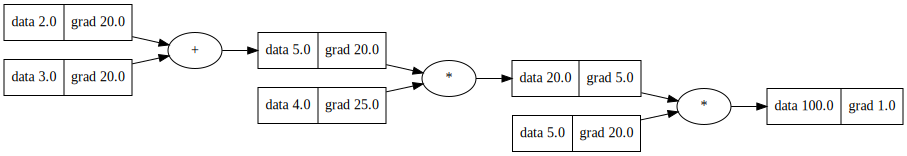

In [ ]:
draw_dot(L)

In [ ]:
def partial(h=0.001):

    a = Tensor(2.0)
    b = Tensor(3.0)
    c = Tensor(4.0)
    x = Tensor(5.0)
    d = a + b
    e = c * d
    L1 = e * x

    a = Tensor(2.0)
    b = Tensor(3.0) + h
    c = Tensor(4.0)
    x = Tensor(5.0)
    d = a + b
    e = c * (d)
    L2 = (e) * (x)

    print((L2.data-L1.data)/h)

partial()

19.99999999998181


In [ ]:
c.grad = 25.0
d.grad = 20.0

# self._backward

In [ ]:
class Tensor:

    def __init__(self, data, prev=(), op=""):
        self.data = data
        self.prev = prev
        self.op = op
        self.grad = 0.0
        self._backward = lambda: None

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data + other.data, prev=(self, other), op="+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data * other.data, prev=(self, other), op="*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        out = Tensor(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out


    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()



    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def relu(self):
        out = Tensor(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def __repr__(self):
        return f"Tensor(data={self.data})"